## Deep Learning Basics

In this tutorial we we will implement a toy deep learning framework, to rapidly create neural network models. It should have some flexibilty and will be implemented so that new modules can be added and replaced just like in modern deep learning frameworks such as pytorch. We will be implementing some types of basic layers. We will also explore pytorch's nn package and see how pytorch accomplishes this goal and what are the extras that pytorch offers.


### 1. Cleaner mini-batch-capable Linear + Softmax classifier


In the previous assignment, we provided a basic implementation of a linear softmax classifier. In this assignment we will use this as a starting point for our deep learning library. 

**Softmax + Negative Log-Likelihood:** First we will re-implement the (softmax + negative log likelihood loss) computation, and its gradient computation. But we will additionally support batches of inputs and labels. 


In [2]:
import torch


# This class combines Softmax + Negative-log likelihood loss.
# Similar to the previous lab, but this implementation works for
# batches of inputs and not just individual input vectors.
# Here "inputs" is batchSize x sizePredictionScores, and
#      "labels" is a vector of size batchSize.
class toynn_CrossEntropyLoss(object):

    # Forward pass: -log softmax(input_{label})
    def forward(self, scores, labels):

        # 1. Computing the softmax: exp(x) / sum (exp(x))
        max_val = scores.max()  # This is to avoid variable overflows.
        exp_inputs = (scores - max_val).exp()
        # This is different than in the previous lab. Avoiding for loops here.
        denominators = exp_inputs.sum(1).repeat(scores.size(1), 1).t()
        self.predictions = torch.mul(exp_inputs, 1 / denominators)

        # 2. Computing the loss: -log(y_label).
        # Check what gather does. Just avoiding another for loop here.
        return -self.predictions.log().gather(1, labels.view(-1, 1)).mean()

    # Backward pass: y_hat - y
    def backward(self, scores, labels):

        # Here we avoid computing softmax again in backward pass.
        grad_inputs = self.predictions.clone()

        # Ok, Here we will use a for loop (but it is avoidable too).
        for i in range(0, scores.size(0)):
            grad_inputs[i][labels[i]] = grad_inputs[i][labels[i]] - 1

        return grad_inputs


# Let's verify if the above seems to be Okay.
batchSize = 32
mock_scores = torch.zeros(batchSize, 10).normal_(0, 0.1)
mock_labels = torch.zeros(batchSize, 1, dtype=torch.long).fill_(3)

loss_fn = toynn_CrossEntropyLoss()

loss = loss_fn.forward(mock_scores, mock_labels)
mock_scores_grads = loss_fn.backward(mock_scores, mock_labels)

print("Input predictions: ", mock_scores.shape)
print("Input labels: ", mock_labels.shape)
print("Output loss: ", loss.item())
print("Input prediction gradients: ", mock_scores_grads.shape)

Input predictions:  torch.Size([32, 10])
Input labels:  torch.Size([32, 1])
Output loss:  2.295161008834839
Input prediction gradients:  torch.Size([32, 10])



**Linear Transformation:**  Next, we will re-implement the linear transformation computation $y=Wx+b$, and its gradient computation. But we will additionally support batches of inputs and labels. Making a batched implementation of this layer is easier because the only change is that now we have matrix-matrix multiplications as opposed to vector-matrix multiplications. Additionally, we will support returning the gradients with respect to the inputs to the linear transformation ($\partial \ell / \partial x_j$). Notice that in our previous assignment we were only concerned with computing $\partial \ell / \partial w_{ij}$ and  $\partial \ell / \partial b_i$ (gradients for the parameters).

In [2]:
class toynn_Linear(object):
    def __init__(self, numInputs, numOutputs):
        # Allocate tensors for the weight and bias parameters.
        self.weight = torch.Tensor(numInputs, numOutputs).normal_(0, 0.01)
        self.weight_grads = torch.Tensor(numInputs, numOutputs)
        self.bias = torch.Tensor(numOutputs).zero_()
        self.bias_grads = torch.Tensor(numOutputs)
    
    # Forward pass, inputs is a matrix of size batchSize x numInputs.
    # Notice that compared to the previous assignment, each input vector
    # is a row in this matrix.
    def forward(self, inputs):
        # This one needs no change, it just becomes 
        # a matrix x matrix multiplication
        # as opposed to just vector x matrix multiplication as we had before.
        return torch.matmul(inputs, self.weight) + self.bias
    
    # Backward pass, in addition to compute gradients for the weight and bias.
    # It has to compute gradients with respect to inputs. 
    def backward(self, inputs, scores_grads):
        self.weight_grads = torch.matmul(inputs.t(), scores_grads)
        self.bias_grads = scores_grads.sum(0)
        return torch.matmul(scores_grads, self.weight.t())

# Input: batchSize x numInputs.
numInputs = 1 * 28 * 28
mock_inputs = torch.Tensor(batchSize, numInputs).normal_(0, 0.1)

# Create the linear object to use.
linear = toynn_Linear(numInputs, 10)

# Forward and Backward passes:
scores = linear.forward(mock_inputs)
mock_inputs_grads = linear.backward(mock_inputs, mock_scores_grads)

print("Input x: ", mock_inputs.shape)
print("Weights W: ", linear.weight.shape)
print("Biases b: ", linear.bias.shape)
print("Outputs: ", scores.shape)
print("dL / dx: ", mock_inputs_grads.shape)

Input x:  torch.Size([32, 784])
Weights W:  torch.Size([784, 10])
Biases b:  torch.Size([10])
Outputs:  torch.Size([32, 10])
dL / dx:  torch.Size([32, 784])


We are finished with a cleaner implementation of the linear + softmax + negative log-likelihood classifier that we implemented for the previous assignment: (1) It supports batches,  (2) the functions for forward and backward are nicely packaged in a python class, (3) the weight and bias matrices (as well as weight_grad and bias_grad matrices) are nicely created and initialized in the constructor of the toynn_Linear class, (4) the Linear class also computes $\partial \ell / \partial x_j$'s, which will be useful to stack layers in order to train deeper models.

### 2. Mini-batch SGD on FashionMNIST


Given the newly implemented toynn_CrossEntropyLoss and toynn_Linear classes, let's train a classifier which is exactly the same as in the previous assignment, but now we can use batches of examples, as opposed to single examples during training with Stochastic (mini-batch) Gradient Descent (SGD). There are a few changes to make to the code from the previous assignment

In [3]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

# Removes, the need to call F.to_image ourselves.
# Also, please look up what transforms.Normalize does.
transform = transforms.Compose([transforms.ToTensor()])

# Load the training, and validation datasets.
trainset = FashionMNIST(root = './data', train = True, transform = transform, download = True)
valset = FashionMNIST(root = './data', train = False, transform = transform, download = True)

# NEW: Pytorch DataLoader for iterating over batches.
batchSize = 100

# Shuffling is needed in case dataset is not shuffled by default.
train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                           batch_size = batchSize,
                                           shuffle = True)
# We don't need to bach the validation set but let's do it anyway.
val_loader = torch.utils.data.DataLoader(dataset = valset,
                                         batch_size = batchSize,
                                         shuffle = False) # No need.

# Define a learning rate. 
learningRate = 1e-4

# Define number of epochs.
N = 5

# Create the model.
loss_fn = toynn_CrossEntropyLoss()
linear_fn = toynn_Linear(1 * 28 * 28, 10)


# log accuracies and losses.
train_accuracies = []; val_accuracies = []
train_losses = []; val_losses = []

# Training loop. Please make sure you understand every single line of code below.
# Go back to some of the previous steps in this lab if necessary.
for epoch in range(0, N):
    correct = 0.0
    cum_loss = 0.0
    
    # Make a pass over the training data.
    for (i, (inputs, labels)) in enumerate(train_loader):
        inputs = inputs.view(batchSize, 1 * 28 * 28)
        
        # Forward pass. (Prediction stage)
        scores = linear_fn.forward(inputs)
        cum_loss += loss_fn.forward(scores, labels).item()
        
        # Count how many correct in this batch.
        max_scores, max_labels = scores.max(1)
        correct += (max_labels == labels).sum().item()
        
        #Backward pass. (Gradient computation stage)
        scores_grads = loss_fn.backward(scores, labels)
        grad_inputs = linear_fn.backward(inputs, scores_grads)
        
        # Parameter updates (SGD step).
        linear_fn.weight.add_(-learningRate, linear_fn.weight_grads)
        linear_fn.bias.add_(-learningRate, linear_fn.bias_grads)
        
        # Logging the current results on training.
        if (i + 1) % 100 == 0:
            print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                  (epoch, i + 1, cum_loss / (i + 1), correct / (i * batchSize + 1)))
    
    train_accuracies.append(correct / len(trainset))
    train_losses.append(cum_loss / len(trainset))
    
    
    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    for (i, (inputs, labels)) in enumerate(val_loader):
        inputs = inputs.view(batchSize, 1 * 28 * 28)
        
        # Forward pass. (Prediction stage)
        scores = linear_fn.forward(inputs)
        cum_loss += loss_fn.forward(scores, labels).item()
        
         # Count how many correct in this batch.
        max_scores, max_labels = scores.max(1)
        correct += (max_labels == labels).sum().item()
          
    val_accuracies.append(correct / len(valset))
    val_losses.append(cum_loss / (i + 1))
            
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
          (epoch, cum_loss / (i + 1), correct / len(valset)))

Train-epoch 0. Iteration 00100, Avg-Loss: 1.6845, Accuracy: 0.5635
Train-epoch 0. Iteration 00200, Avg-Loss: 1.4278, Accuracy: 0.6233
Train-epoch 0. Iteration 00300, Avg-Loss: 1.2883, Accuracy: 0.6468
Train-epoch 0. Iteration 00400, Avg-Loss: 1.1924, Accuracy: 0.6648
Train-epoch 0. Iteration 00500, Avg-Loss: 1.1253, Accuracy: 0.6798
Train-epoch 0. Iteration 00600, Avg-Loss: 1.0746, Accuracy: 0.6901
Validation-epoch 0. Avg-Loss: 0.8133, Accuracy: 0.7363
Train-epoch 1. Iteration 00100, Avg-Loss: 0.7722, Accuracy: 0.7651
Train-epoch 1. Iteration 00200, Avg-Loss: 0.7669, Accuracy: 0.7645
Train-epoch 1. Iteration 00300, Avg-Loss: 0.7598, Accuracy: 0.7658
Train-epoch 1. Iteration 00400, Avg-Loss: 0.7511, Accuracy: 0.7680
Train-epoch 1. Iteration 00500, Avg-Loss: 0.7389, Accuracy: 0.7707
Train-epoch 1. Iteration 00600, Avg-Loss: 0.7322, Accuracy: 0.7722
Validation-epoch 1. Avg-Loss: 0.7020, Accuracy: 0.7713
Train-epoch 2. Iteration 00100, Avg-Loss: 0.6760, Accuracy: 0.7952
Train-epoch 2. Iter

We achieved an accuracy of 80% a lot faster than in the previous assignment, in fact we reached almost 83% in the same amount of epochs as before, so it seems mini-batching is helping to some extent. Try experimenting with different batch sizes and learning rates. Batch-size and learning rate are two hyper-parameters that are related in the optimization process, and is a current line of active research. For instance, under deep learning models, larger batch sizes do not offer as good generalization as smaller batches, which is bad because it is easier to parallelize code when using larger batch sizes. Also, a common strategy during training is to reduce (decay) the learning rate, as the training progresses to the later epochs, but a recent paper proposed to increase the batch size instead (for more, see: https://arxiv.org/abs/1711.00489 ). Probably for small datasets, keeping the learning rate fixed and batch size fixed will be fine, but as one moves to larger datasets, and deeper models, it becomes crucial to use some more advanced strategies.

### 3. The Rectified Linear Unit (ReLU) Activation Function.


We are close to implementing a neural network, we can accomplish this by stacking a linear operation on top of a Rectified Linear Unit (ReLU) activation, another linear operation, and the softmax + negative log likelihood loss. This is all it takes to create simple neural network with one hidden layer. First, let's implement the ReLU layer as we implemented the linear layer. 

In [4]:
class toynn_ReLU(object):
  
    # Forward operation: f(x_i) = max(0, x_i)
    def forward(self, inputs):
        outputs = inputs.clone()
        outputs[outputs < 0] = 0
        return outputs
    
    # Make sure the backward pass is absolutely clear.
    def backward(self, inputs, outputs_grad):
        inputs_grad = outputs_grad.clone() # 1 * previous_grads
        inputs_grad[inputs < 0] = 0  # or zero.
        return inputs_grad
      
# Let's test it.
x = torch.tensor([-2.3, 2.3, 3.1, -1.3, 4.3])
relu_fn = toynn_ReLU()

print("Input x: ", x)
print("Output: ", relu_fn.forward(x))
print("Grad x: ", relu_fn.backward(x, torch.ones(5)))

Input x:  tensor([-2.3000,  2.3000,  3.1000, -1.3000,  4.3000])
Output:  tensor([0.0000, 2.3000, 3.1000, 0.0000, 4.3000])
Grad x:  tensor([0., 1., 1., 0., 1.])


### 4. Forward Pass in a Two-Layer Neural Network

We are going to show here how to perform inference in a two-layer neural network using the operations defined earlier. In the questions for the assignment it is your task to train this network and demonstrate superior accuracy.

In [5]:
import matplotlib
matplotlib.rc('image', cmap = 'gray')
import matplotlib.pyplot as plt

# Setup the input variable x.
img, label = trainset[0]
x = img.view(1, 1 * 28 * 28)

# Setup the number of inputs, hidden neurons, and outputs.
nInputs = 1 * 28 * 28
nHidden = 512
nOutputs = 10

# Create the model here.
linear_fn1 = toynn_Linear(nInputs, nHidden)
relu_fn = toynn_ReLU()
linear_fn2 = toynn_Linear(nHidden, nOutputs)

# Make predictions.
a = linear_fn1.forward(x)
z = relu_fn.forward(a)
yhat = linear_fn2.forward(z)

# Show the prediction scores for each class.
# Yes, pytorch tensors already come with a softmax function.
# We need it here because we hard-coded the softmax inside 
# the loss function.
print(yhat.softmax(dim = 1)) 

plt.imshow(img[0]); plt.axis('off'); plt.grid(False)

tensor([[0.1012, 0.0980, 0.0986, 0.0984, 0.1002, 0.1020, 0.0997, 0.0950, 0.1026,
         0.1043]])


Since the weights, and biases in the two linear layers [linear_fn1, linear_fn2] are not trained, the predictions are arbitrary at this point. One of the tasks for this assignment is for you to train the neural network.

## Assignment Questions [100pts + 30pts (optional extra credit)]

### 1. Activation Functions (30pts)



Provide code for the following activation functions:

$$\text{Sigmoid(x)} = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}$$

$$\text{Tanh(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

$$ \text{LeakyReLU}(x) = \begin{cases} 
      0.01 x & x < 0 \\
      x & x \geq 0 
\end{cases}$$

In [7]:
# Sigmoid of x.
import numpy as np
import torch
#-------------------------------------------------------------------------------------------------------------------
class toynn_Sigmoid:
    def forward(self, x):
        # Forward pass.
        outputs = x.clone()
        outputs = x.exp() / (x.exp() + 1)
        return outputs
    
    def backward(self, x, output_grads):
        # Backward pass
        inputs_grad = output_grads.clone() 
        sigmoid = x.exp() / (x.exp() + 1)
        return np.multiply(np.multiply(sigmoid, (1 - sigmoid)), inputs_grad)
#-------------------------------------------------------------------------------------------------------------------
# Hyperbolic tangent.
class toynn_Tanh:
    def forward(self, x):
        # Forward pass.
        outputs = x.clone()
        outputs = np.tanh(outputs)
        return outputs
    
    def backward(self, x, output_grads):
        # Backward pass
        inputs_grad = output_grads.clone() 
        tanh = np.tanh(x)
        return np.multiply(1 - (tanh ** 2), inputs_grad)
#-------------------------------------------------------------------------------------------------------------------
# LeakyReLU of x.
class toynn_LeakyReLU:
    def forward(self, inputs):
        outputs = inputs.clone()
        outputs[outputs < 0] *= .01
        return outputs
    
    # Make sure the backward pass is absolutely clear.
    def backward(self, inputs, outputs_grad):
        inputs_grad = outputs_grad.clone() 
        inputs_grad[inputs < 0] = .01  
        inputs_grad[inputs >= 0] = 1  
        return np.multiply(inputs_grad, outputs_grad)
#-------------------------------------------------------------------------------------------------------------------

print('-' * 50)
print('Sigmoid Example')
print('-' * 50)
x = torch.tensor([-2.3, 2.3, 3.1, -1.3, 4.3])
sigmoid = toynn_Sigmoid()
print('input:', x)
print('output:', sigmoid.forward(x))
print('grad', sigmoid.backward(x, torch.ones(5)))
#-------------------------------------------------------------------------------------------------------------------


print('-' * 50)
print('Tanh Example')
print('-' * 50)
tanh = toynn_Tanh()
print('input:', x)
print('output:', tanh.forward(x))
print('grad', tanh.backward(x, torch.ones(5)))
#-------------------------------------------------------------------------------------------------------------------


print('-' * 50)
print('Leaky Relu Example')
print('-' * 50)
leaky_relu = toynn_LeakyReLU()
print('input:', x)
print('output:', leaky_relu.forward(x))
print('grad', leaky_relu.backward(x, torch.ones(5)))
#-------------------------------------------------------------------------------------------------------------------

--------------------------------------------------
Sigmoid Example
--------------------------------------------------
input: tensor([-2.3000,  2.3000,  3.1000, -1.3000,  4.3000])
output: tensor([0.0911, 0.9089, 0.9569, 0.2142, 0.9866])
grad tensor([0.0828, 0.0828, 0.0412, 0.1683, 0.0132])
--------------------------------------------------
Tanh Example
--------------------------------------------------
input: tensor([-2.3000,  2.3000,  3.1000, -1.3000,  4.3000])
output: tensor([-0.9801,  0.9801,  0.9959, -0.8617,  0.9996])
grad tensor([0.0394, 0.0394, 0.0081, 0.2574, 0.0007])
--------------------------------------------------
Leaky Relu Example
--------------------------------------------------
input: tensor([-2.3000,  2.3000,  3.1000, -1.3000,  4.3000])
output: tensor([-0.0230,  2.3000,  3.1000, -0.0130,  4.3000])
grad tensor([0.0100, 1.0000, 1.0000, 0.0100, 1.0000])


### 2. Binary Cross Entropy (BCE) loss function: (20pts)



Provide code for the binary cross entropy loss function as defined below:

$$\ell(y, \hat{y}) = -\sum_{i=1}^{i=n} [y_i\text{log}(\hat{y}_i) + (1 - y_i)\text{log}(1 - \hat{y}_i)]$$,

where $n$ is the number of outputs (e.g. the size of vectors $y$ and $\hat{y}$), the entries in the target vector $y_i$ are binary $\in \{0,1\}$ and $y_i$ are typically the outputs of a sigmoid layer. Remember that the backward pass does not return a scalar but a vector containing the values for $\partial \ell / \partial \hat{y}_i$, henceforth a vector of the same size as $\hat{y}$.

In [10]:
import torch.nn as nn

# Binary cross entropy loss.
# Useful for classification when the classes are not mutually exclusive.
# For instance, when both shoe, and dress, are correct labels for an image.
# In other words, when images have multiple labels per image.
class toynn_BCELoss:
    def forward(self, predictions, targets):
        # Forward pass.

        return -((predictions.log() * targets) +
                 ((1 - targets) * (1 - predictions).log())).mean()

    def backward(self, predictions, targets):
        # Backward pass.
        grad_inputs = predictions.clone()
        lst = []
        for i in range(len(predictions)):
            #grad_inputs[i] = -np.log(predictions[i]) * targets[i] + -np.log(1 - predictions[i]) * (1 - targets[i])
            grad_inputs[i] = (targets[i] / predictions[i]) + ((1-targets[i]) / (1- predictions[i]))
        return grad_inputs


#-------------------------------------------------------------------------------------------------------------------
x0 = torch.randn(3)
y = torch.FloatTensor(3).random_(2)


print('-' * 50)
print('Raw Numpy / Torch')
print('-' * 50)
bse_loss = toynn_BCELoss()


x = sigmoid.forward(x0)
print('x:', x)
print('y:', y)
loss = bse_loss.forward(predictions=x, targets=y)
print('loss:', loss)
print('grads',bse_loss.backward(predictions=x, targets=y))

#-------------------------------------------------------------------------------------------------------------------

print('-' * 50)
print('Torch') #https://github.com/yang-zhang/yang-zhang.github.io/blob/master/ds_code/pytorch-losses-in-plain-python.ipynb
print('-' * 50)
loss_fcn = nn.BCELoss()
x = nn.Sigmoid()(x0)
print('x:', x)
print('y:', y)
print('loss:', loss_fcn(x, y))

grads = []
for i in range(len(x)):
    #grad_inputs[i] = -np.log(predictions[i]) * targets[i] + -np.log(1 - predictions[i]) * (1 - targets[i])
    grads.append((y[i] / x[i]) + ((1-y[i]) / (1- x[i])))
print(grads)






--------------------------------------------------
Raw Numpy / Torch
--------------------------------------------------
x: tensor([0.4018, 0.2160, 0.3881])
y: tensor([0., 0., 0.])
loss: tensor(0.4161)
grads tensor([1.6716, 1.2755, 1.6343])
--------------------------------------------------
Torch
--------------------------------------------------
x: tensor([0.4018, 0.2160, 0.3881])
y: tensor([0., 0., 0.])
loss: tensor(0.4161)
[tensor(1.6716), tensor(1.2755), tensor(1.6343)]


### 3. Training of the Two Layer NN (50pts)


Train the two-layer Neural Network as defined in Section 3 of this Assignment on FashionMNIST using toynn. Include below the code for training this neural network and report the training, validation plots for loss and accuracy. The code should be similar to the code in Section 2 of this assignment, please follow that convention.

In [8]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

# Removes, the need to call F.to_image ourselves.
# Also, please look up what transforms.Normalize does.
transform = transforms.Compose([transforms.ToTensor()])

# Load the training, and validation datasets.
trainset = FashionMNIST(root = './data', train = True, transform = transform, download = True)
valset = FashionMNIST(root = './data', train = False, transform = transform, download = True)

# NEW: Pytorch DataLoader for iterating over batches.
batchSize = 200

# Shuffling is needed in case dataset is not shuffled by default.
train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                           batch_size = batchSize,
                                           shuffle = True)

# We don't need to bach the validation set but let's do it anyway.
val_loader = torch.utils.data.DataLoader(dataset = valset,
                                         batch_size = batchSize,
                                         shuffle = False) # No need.
#-------------------------------------------------------------------------------------------------------------------
# Define a learning rate.
learningRate = 1e-3

# Define number of epochs.
N = 50

# Create the model.
n_inputs = 1 * 28 * 28
nHidden = 1024  #Neurons
nOutputs = 10  #10 classes on fashionmnist

model = {}
model['linear1'] = toynn_Linear(n_inputs, nHidden)
model['sigmoid'] = toynn_Sigmoid()
model['linear2'] = toynn_Linear(nHidden, nOutputs)
model['loss'] = toynn_CrossEntropyLoss()

# log accuracies and losses.
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
#-------------------------------------------------------------------------------------------------------------------

# Training loop. Please make sure you understand every single line of code below.
# Go back to some of the previous steps in this lab if necessary.
for epoch in range(0, N):
    correct = 0.0
    cum_loss = 0.0

    # Make a pass over the training data.
    for (i, (inputs, labels)) in enumerate(train_loader):
        # .view appears to be similar to np.reshape. We're just flattening and reshaping inputs into a new tensor shape here.
        inputs = inputs.view(
            batchSize,
            n_inputs)  #Returns Torch Tensor batchSize X Image Size Flattened
#-------------------------------------------------------------------------------------------------------------------
        #Forward
        a = model['linear1'].forward(inputs)  # torch.Size([100, 512])
        z = model['sigmoid'].forward(a)  # torch.Size([100, 512])
        y_hat = model['linear2'].forward(
            z
        )  # torch.Size([100, 10]) #This is computed as softmax in the loss for CrossEntropy

        cum_loss += model['loss'].forward(y_hat, labels).item()

        # Count how many correct in this batch.
        max_scores, max_labels = y_hat.max(1)
        correct += (max_labels == labels).sum().item()
#-------------------------------------------------------------------------------------------------------------------

        #Backward pass. (Gradient computation stage)
        y_hat_grads = model['loss'].backward(y_hat,
                                             labels)  #torch.Size([10, 10])
        z_grads = model['linear2'].backward(z, y_hat_grads)
        a_grads = model['sigmoid'].backward(a, z_grads)
        x_grads = model['linear1'].backward(inputs, a_grads)
#-------------------------------------------------------------------------------------------------------------------

        # Parameter updates (SGD step).
        model['linear1'].weight.add_(-learningRate,
                                     model['linear1'].weight_grads)
        model['linear1'].bias.add_(-learningRate, model['linear1'].bias_grads)
        model['linear2'].weight.add_(-learningRate,
                                     model['linear2'].weight_grads)
        model['linear2'].bias.add_(-learningRate, model['linear2'].bias_grads)
#-------------------------------------------------------------------------------------------------------------------

        # Logging the current results on training.
        if (i + 1) % 150 == 0:
            print(
                'Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f'
                % (epoch, i + 1, cum_loss / (i + 1), correct /
                   (i * batchSize + 1)))

    train_accuracies.append(correct / len(trainset))
    train_losses.append(cum_loss / len(trainset))
#-------------------------------------------------------------------------------------------------------------------

    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    for (i, (inputs, labels)) in enumerate(val_loader):
        inputs = inputs.view(batchSize, n_inputs)

        #Forward
        a = model['linear1'].forward(inputs)  # torch.Size([100, 512])
        z = model['sigmoid'].forward(a)  # torch.Size([100, 512])
        #This is computed as softmax in the loss for CrossEntropy
        y_hat = model['linear2'].forward(z)  # torch.Size([100, 10])

        cum_loss += model['loss'].forward(y_hat, labels).item()

        # Count how many correct in this batch.
        max_scores, max_labels = y_hat.max(1)
        correct += (max_labels == labels).sum().item()

    val_accuracies.append(correct / len(valset))
    val_losses.append(cum_loss / (i + 1))

    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' %
          (epoch, cum_loss / (i + 1), correct / len(valset)))

Train-epoch 0. Iteration 00150, Avg-Loss: 2.0956, Accuracy: 0.3921
Train-epoch 0. Iteration 00300, Avg-Loss: 1.4772, Accuracy: 0.5370
Validation-epoch 0. Avg-Loss: 0.7552, Accuracy: 0.7139
Train-epoch 1. Iteration 00150, Avg-Loss: 0.6913, Accuracy: 0.7412
Train-epoch 1. Iteration 00300, Avg-Loss: 0.6609, Accuracy: 0.7518
Validation-epoch 1. Avg-Loss: 0.6029, Accuracy: 0.7741
Train-epoch 2. Iteration 00150, Avg-Loss: 0.5850, Accuracy: 0.7860
Train-epoch 2. Iteration 00300, Avg-Loss: 0.5700, Accuracy: 0.7922
Validation-epoch 2. Avg-Loss: 0.5850, Accuracy: 0.7907
Train-epoch 3. Iteration 00150, Avg-Loss: 0.5304, Accuracy: 0.8152
Train-epoch 3. Iteration 00300, Avg-Loss: 0.5204, Accuracy: 0.8138
Validation-epoch 3. Avg-Loss: 0.5319, Accuracy: 0.8040
Train-epoch 4. Iteration 00150, Avg-Loss: 0.4929, Accuracy: 0.8284
Train-epoch 4. Iteration 00300, Avg-Loss: 0.4938, Accuracy: 0.8244
Validation-epoch 4. Avg-Loss: 0.5101, Accuracy: 0.8122
Train-epoch 5. Iteration 00150, Avg-Loss: 0.4772, Accur

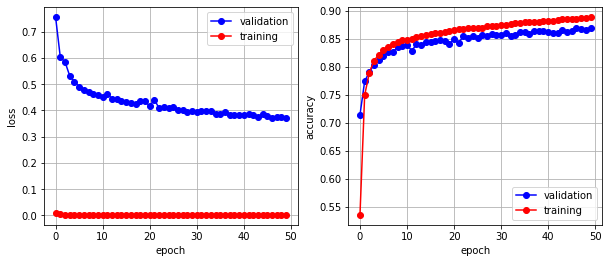

In [10]:
# Your code for visualizing train/val plots for accuracy and losses.
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label='val-loss')
plt.plot(train_losses, 'ro-', label='train-loss')
plt.grid('on')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')
#-------------------------------------------------------------------------------------------------------------------
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label='val-acc')
plt.plot(train_accuracies, 'ro-', label='train-acc')
plt.ylabel('accuracy')
plt.grid('on')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()

### 4. The CIFAR 10 Dataset (torchvision.datasets.CIFAR10). (30pts)

Include the code for defining, and training the neural network, as well as plots for training, validation for loss and accuracy. Show the predictions for one example of this dataset. Write down below your code in bold face the accuracy you obtained and in how many epochs. I will post the highest accuracies that people obtained for this part.

In [535]:
from torchvision.datasets import CIFAR10
#-------------------------------------------------------------------------------------------------------------------

# Removes, the need to call F.to_image ourselves.
# Also, please look up what transforms.Normalize does.
transform = transforms.Compose([transforms.ToTensor()])

# Load the training, and validation datasets.
trainset = CIFAR10(root='./data',
                   train=True,
                   transform=transform,
                   download=True)
valset = CIFAR10(root='./data',
                 train=False,
                 transform=transform,
                 download=True)

batch_size = 128

# Shuffling is needed in case dataset is not shuffled by default.
train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batchSize,
                                           shuffle=True)

# We don't need to bach the validation set but let's do it anyway.
val_loader = torch.utils.data.DataLoader(dataset=valset,
                                         batch_size=batchSize,
                                         shuffle=False)  # No need.
#-------------------------------------------------------------------------------------------------------------------

# Define a learning rate.
learningRate = 1e-3

# Define number of epochs.
N = 100

# Create the model.
n_inputs = 3 * 32 * 32
nHidden = 524  #Neurons
nOutputs = 10  #10 classes on fashionmnist
#-------------------------------------------------------------------------------------------------------------------

model = {}
model['linear1'] = toynn_Linear(n_inputs, nHidden)
model['relu'] = toynn_ReLU()
model['linear2'] = toynn_Linear(nHidden, nHidden)
model['relu1'] = toynn_ReLU()
model['linear3'] = toynn_Linear(nHidden, nOutputs)
model['loss'] = toynn_CrossEntropyLoss()
#-------------------------------------------------------------------------------------------------------------------

# log accuracies and losses.
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
#-------------------------------------------------------------------------------------------------------------------
saved_models = {}
#-------------------------------------------------------------------------------------------------------------------

# param_grid = {"learning_rate" : [.0001, .001], "nHidden" : [256,512,1024]}



for epoch in range(0, N):
    correct = 0.0
    cum_loss = 0.0

    # Make a pass over the training data.
    for (i, (inputs, labels)) in enumerate(train_loader):
        # .view appears to be similar to np.reshape. We're just flattening and reshaping inputs into a new tensor shape here.
        inputs = inputs.view(
            batchSize, n_inputs)  #Returns Torch Tensor batchSize X Image Size Flattened
#-------------------------------------------------------------------------------------------------------------------
        #Forward
        a = model['linear1'].forward(inputs)  # torch.Size([100, 512])
        z = model['relu'].forward(a)  # torch.Size([100, 512])
        a1 = model['linear2'].forward(
            z
        )  # torch.Size([100, 10]) #This is computed as softmax in the loss for CrossEntropy
        z1 = model['relu1'].forward(a1)
        y_hat = model['linear3'].forward(z1)
        cum_loss += model['loss'].forward(y_hat, labels).item()

        # Count how many correct in this batch.
        max_scores, max_labels = y_hat.max(1)
        correct += (max_labels == labels).sum().item()
#-------------------------------------------------------------------------------------------------------------------

        #Backward pass. (Gradient computation stage)
        y_hat_grads = model['loss'].backward(y_hat,
                                             labels)  #torch.Size([10, 10])
        z1_grads = model['linear3'].backward(z1, y_hat_grads)
        a1_grads = model['relu'].backward(a1, z1_grads)
        z_grads = model['linear2'].backward(z, a1_grads)
        a_grads = model['relu'].backward(a, z_grads)
        x_grads = model['linear1'].backward(inputs, a_grads)
#-------------------------------------------------------------------------------------------------------------------

        # Parameter updates (SGD step).
#         decay = 10.
#         learningRate = (1. / (1. + decay * (epoch+1)))
    
    
        model['linear1'].weight.add_(-learningRate,
                                     model['linear1'].weight_grads)
        model['linear1'].bias.add_(-learningRate, model['linear1'].bias_grads)
        model['linear2'].weight.add_(-learningRate,
                                     model['linear2'].weight_grads)
        model['linear2'].bias.add_(-learningRate, model['linear2'].bias_grads)
#-------------------------------------------------------------------------------------------------------------------

        # Logging the current results on training.
        if (i + 1) % 100 == 0:
            print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                  (epoch, i + 1, cum_loss / (i + 1), correct / (i * batchSize + 1)))
    
    train_accuracies.append(correct / len(trainset))
    train_losses.append(cum_loss / (i + 1))
#-------------------------------------------------------------------------------------------------------------------

    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    for (i, (inputs, labels)) in enumerate(val_loader):
        inputs = inputs.view(batchSize, n_inputs)

        #Forward
        a = model['linear1'].forward(inputs)  # torch.Size([100, 512])
        z = model['relu'].forward(a)  # torch.Size([100, 512])
        a1 = model['linear2'].forward(
            z
        )  # torch.Size([100, 10]) #This is computed as softmax in the loss for CrossEntropy
        z1 = model['relu1'].forward(a1)
        y_hat = model['linear3'].forward(z1)

        cum_loss += model['loss'].forward(y_hat, labels).item()

        # Count how many correct in this batch.
        max_scores, max_labels = y_hat.max(1)
        correct += (max_labels == labels).sum().item()

    val_accuracies.append(correct / len(valset))
    val_losses.append(cum_loss / (i + 1))
        
#-------------------------------------------------------------------------------------------------------------------

    #Early Stopping
    patience = 10
#     if epoch > 5:
#         if not any(i >= val_losses[-1] for i in val_losses[-patience:-1]):
#             print('Early Stopping! Val Loss has not decreased in last %s batch iterations' % patience)
#             break

    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' %
          (epoch, cum_loss / (i + 1), correct / inputs.shape[0]))
    saved_models[epoch] = model #Checkpointing
    print('-' *50)

Files already downloaded and verified
Files already downloaded and verified
Train-epoch 0. Iteration 00100, Avg-Loss: 2.2928, Accuracy: 0.1250
Train-epoch 0. Iteration 00200, Avg-Loss: 2.2670, Accuracy: 0.1480
Train-epoch 0. Iteration 00300, Avg-Loss: 2.2239, Accuracy: 0.1697
Train-epoch 0. Iteration 00400, Avg-Loss: 2.1848, Accuracy: 0.1891
Train-epoch 0. Iteration 00500, Avg-Loss: 2.1511, Accuracy: 0.2055
Validation-epoch 0. Avg-Loss: 1.9938, Accuracy: 26.9500
--------------------------------------------------
Train-epoch 1. Iteration 00100, Avg-Loss: 1.9816, Accuracy: 0.2817
Train-epoch 1. Iteration 00200, Avg-Loss: 1.9634, Accuracy: 0.2942
Train-epoch 1. Iteration 00300, Avg-Loss: 1.9493, Accuracy: 0.2997
Train-epoch 1. Iteration 00400, Avg-Loss: 1.9362, Accuracy: 0.3052
Train-epoch 1. Iteration 00500, Avg-Loss: 1.9258, Accuracy: 0.3100
Validation-epoch 1. Avg-Loss: 1.8672, Accuracy: 32.9200
--------------------------------------------------
Train-epoch 2. Iteration 00100, Avg-Loss

Train-epoch 36. Iteration 00300, Avg-Loss: 1.2352, Accuracy: 0.5708
Train-epoch 36. Iteration 00400, Avg-Loss: 1.2342, Accuracy: 0.5712
Train-epoch 36. Iteration 00500, Avg-Loss: 1.2370, Accuracy: 0.5692
Validation-epoch 36. Avg-Loss: 1.3541, Accuracy: 52.5700
--------------------------------------------------
Train-epoch 37. Iteration 00100, Avg-Loss: 1.2238, Accuracy: 0.5803
Train-epoch 37. Iteration 00200, Avg-Loss: 1.2237, Accuracy: 0.5741
Train-epoch 37. Iteration 00300, Avg-Loss: 1.2255, Accuracy: 0.5734
Train-epoch 37. Iteration 00400, Avg-Loss: 1.2276, Accuracy: 0.5716
Train-epoch 37. Iteration 00500, Avg-Loss: 1.2290, Accuracy: 0.5700
Validation-epoch 37. Avg-Loss: 1.3433, Accuracy: 52.0800
--------------------------------------------------
Train-epoch 38. Iteration 00100, Avg-Loss: 1.2198, Accuracy: 0.5812
Train-epoch 38. Iteration 00200, Avg-Loss: 1.2183, Accuracy: 0.5764
Train-epoch 38. Iteration 00300, Avg-Loss: 1.2199, Accuracy: 0.5767
Train-epoch 38. Iteration 00400, Avg

Train-epoch 72. Iteration 00500, Avg-Loss: 0.9874, Accuracy: 0.6589
Validation-epoch 72. Avg-Loss: 1.3142, Accuracy: 54.0100
--------------------------------------------------
Train-epoch 73. Iteration 00100, Avg-Loss: 0.9869, Accuracy: 0.6675
Train-epoch 73. Iteration 00200, Avg-Loss: 0.9750, Accuracy: 0.6665
Train-epoch 73. Iteration 00300, Avg-Loss: 0.9763, Accuracy: 0.6637
Train-epoch 73. Iteration 00400, Avg-Loss: 0.9812, Accuracy: 0.6613
Train-epoch 73. Iteration 00500, Avg-Loss: 0.9794, Accuracy: 0.6613
Validation-epoch 73. Avg-Loss: 1.2834, Accuracy: 55.6200
--------------------------------------------------
Train-epoch 74. Iteration 00100, Avg-Loss: 0.9624, Accuracy: 0.6749
Train-epoch 74. Iteration 00200, Avg-Loss: 0.9667, Accuracy: 0.6687
Train-epoch 74. Iteration 00300, Avg-Loss: 0.9678, Accuracy: 0.6670
Train-epoch 74. Iteration 00400, Avg-Loss: 0.9698, Accuracy: 0.6655
Train-epoch 74. Iteration 00500, Avg-Loss: 0.9737, Accuracy: 0.6622
Validation-epoch 74. Avg-Loss: 1.364

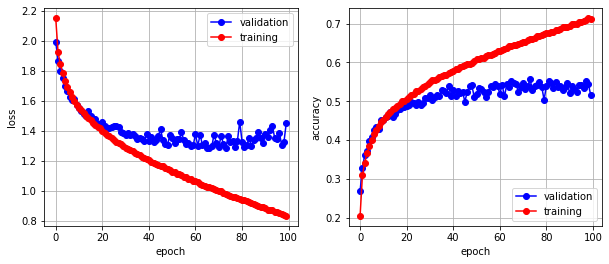

max validation accuracy: 55.62 ; Epochs: 73 


In [536]:
# Your code for visualizing train/val plots for accuracy and losses.
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label='val-loss')
plt.plot(train_losses, 'ro-', label='train-loss')
plt.grid('on')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label='val-acc')
plt.plot(train_accuracies, 'ro-', label='train-acc')
plt.ylabel('accuracy')
plt.grid('on')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()

print('max validation accuracy: %.2f ; Epochs: %.0f ' % (max(val_accuracies) * 100, np.argmax(val_accuracies)))

In [539]:
best_model = saved_models[np.argmax(val_accuracies)]

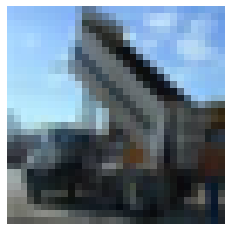

Image 50 is a truck
Model Predicts truck with 96.61 percent confidence


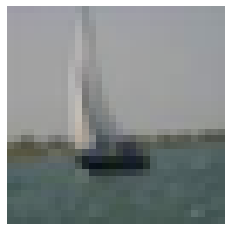

Image 55 is a ship
Model Predicts ship with 50.42 percent confidence


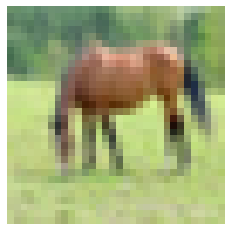

Image 60 is a horse
Model Predicts horse with 63.86 percent confidence


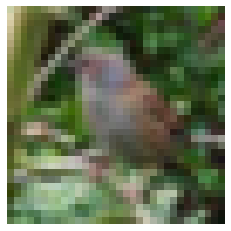

Image 65 is a bird
Model Predicts bird with 87.01 percent confidence


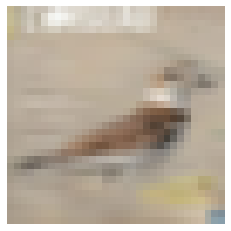

Image 70 is a bird
Model Predicts deer with 37.86 percent confidence


In [541]:
#https://www.cs.toronto.edu/~kriz/cifar.html
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
image_index = [50,55,60,65,70]

for i in image_index:
    img, label = val_loader.dataset[i]
    inputs = img.view(1, n_inputs)

    a = best_model['linear1'].forward(inputs)  # torch.Size([100, 512])
    z = best_model['relu'].forward(a)  # torch.Size([100, 512])
    a1 = best_model['linear2'].forward(
        z
    )  # torch.Size([100, 10]) #This is computed as softmax in the loss for CrossEntropy
    z1 = best_model['relu1'].forward(a1)
    y_hat = best_model['linear3'].forward(z1)

    max_scores, max_labels = y_hat.softmax(dim = 1).max(1)

    plt.figure()
    plt.imshow(img.transpose(0,2).transpose(0,1));
    plt.grid(False); plt.axis('off')
    plt.show()
    print('Image {0} is a {1}'.format(i, classes[label]))
    print('Model Predicts %s with %.2f percent confidence' % (classes[max_labels], max_scores[0] * 100))


**I obtained a validation accuracy of 55.62% after 73 epochs. Best model was checkpointed and used for inference.**
